# Projet d'apprentissage profond pour les images - Quang-Duy Nguyen, Morgan Ramadani
## 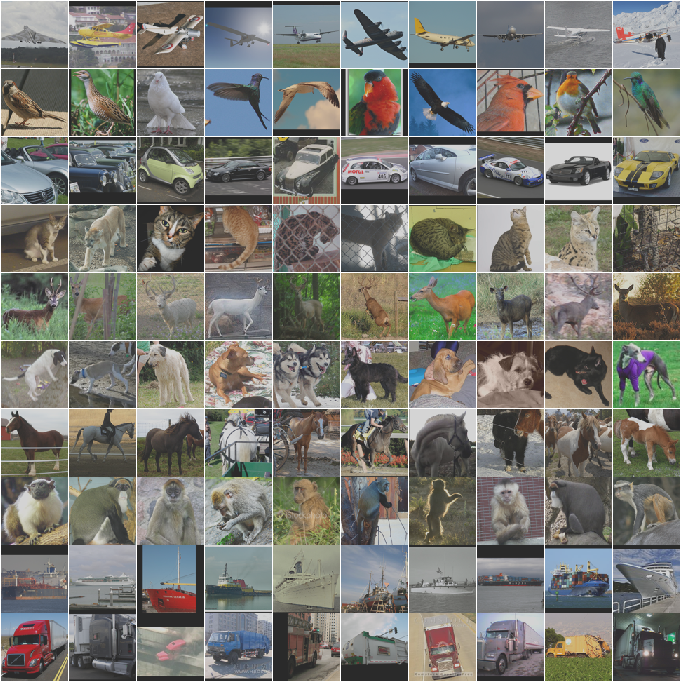

## Installation & Imports

sys.version_info(major=3, minor=9, micro=7, releaselevel='final', serial=0)


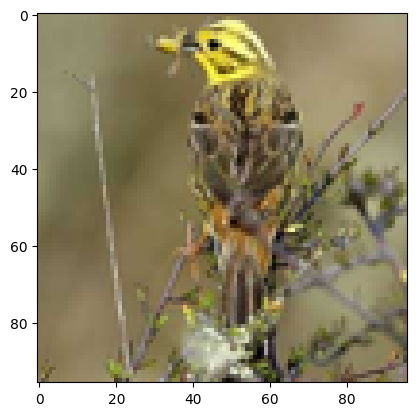

(5000, 96, 96, 3)
(5000,)


In [15]:
from __future__ import print_function

import sys
import os, sys, tarfile, errno
import numpy as np
import matplotlib.pyplot as plt
import random
from keras.preprocessing.image import save_img

if sys.version_info >= (3, 0, 0):
    import urllib.request as urllib # ugly but works
else:
    import urllib

try:
    from imageio import imsave
except:
    from keras.preprocessing.image import save_img
    # from scipy.misc import imsave

print(sys.version_info)

# image shape
HEIGHT = 96
WIDTH = 96
DEPTH = 3

# size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH

# path to the directory with the data
DATA_DIR = './data'

# url of the binary data
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'

# path to the binary train file with image data
DATA_PATH = './data/stl10_binary/train_X.bin'

# path to the binary train file with labels
LABEL_PATH = './data/stl10_binary/train_y.bin'

def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels


def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images


def read_single_image(image_file):
    """
    CAREFUL! - this method uses a file as input instead of the path - so the
    position of the reader will be remembered outside of context of this method.
    :param image_file: the open file containing the images
    :return: a single image
    """
    # read a single image, count determines the number of uint8's to read
    image = np.fromfile(image_file, dtype=np.uint8, count=SIZE)
    # force into image matrix
    image = np.reshape(image, (3, 96, 96))
    # transpose to standard format
    # You might want to comment this line or reverse the shuffle
    # if you will use a learning algorithm like CNN, since they like
    # their channels separated.
    image = np.transpose(image, (2, 1, 0))
    return image


def plot_image(image):
    """
    :param image: the image to be plotted in a 3-D matrix format
    :return: None
    """
    plt.imshow(image)
    plt.show()

def save_image(image, name):
    save_img("%s.png" % name, image, format="png")

def download_and_extract():
    """
    Download and extract the STL-10 dataset
    :return: None
    """
    dest_directory = DATA_DIR
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\rDownloading %s %.2f%%' % (filename,
                float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.urlretrieve(DATA_URL, filepath, reporthook=_progress)
        print('Downloaded', filename)
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)

def save_images(images, labels):
    print("Saving images to disk")
    i = 0
    for image in images:
        label = labels[i]
        directory = './img/' + str(label) + '/'
        try:
            os.makedirs(directory, exist_ok=True)
        except OSError as exc:
            if exc.errno == errno.EEXIST:
                pass
        filename = directory + str(i)
        print(filename)
        save_image(image, filename)
        i = i+1

if __name__ == "__main__" :
    # download data if needed
    download_and_extract()

    # test to check if the image is read correctly
    with open(DATA_PATH) as f:
        image = read_single_image(f)
        plot_image(image)

    # test to check if the whole dataset is read correctly
    images = read_all_images(DATA_PATH)
    print(images.shape)

    labels = read_labels(LABEL_PATH)
    print(labels.shape)

    # save images to disk
    # save_images(images, labels)

In [16]:
images = read_all_images(DATA_PATH)

labels = read_labels(LABEL_PATH)

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import cv2

## Data Exploration

In [21]:
# Vérifier qu'il y a pas de déséquilibre de classes
print(np.array(np.unique(labels, return_counts=True)).T)

[[  1 500]
 [  2 500]
 [  3 500]
 [  4 500]
 [  5 500]
 [  6 500]
 [  7 500]
 [  8 500]
 [  9 500]
 [ 10 500]]


In [22]:
print(images.shape)
for i in images :
    if i.shape != (96, 96, 3):
        print('dimension problem')

(5000, 96, 96, 3)


## Splitting Data

In [67]:
# Division des données en ensembles d'entraînement et de test (80% pour l'entraînement, 20% pour le test)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Division de l'ensemble d'entraînement en ensembles d'entraînement et de validation (80% pour l'entraînement, 20% pour la validation)
train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Convertir les étiquettes en codage à chaud (one-hot encoding)
num_classes = 10
train_labels = tf.keras.utils.to_categorical(train_labels-1, num_classes)
valid_labels = tf.keras.utils.to_categorical(valid_labels-1, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels-1, num_classes)


# Vérification des dimensions des ensembles
print("Training set:", train_images.shape, train_labels.shape)
print("Validation set:", valid_images.shape, valid_labels.shape)
print("Test set:", test_images.shape, test_labels.shape)


Training set: (3200, 96, 96, 3) (3200, 10)
Validation set: (800, 96, 96, 3) (800, 10)
Test set: (1000, 96, 96, 3) (1000, 10)


## Baseline

### Baseline w/o Attention

In [24]:
input_shape = (96, 96, 3)

inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='linear')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 32)        4640  

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(
                    train_images, train_labels,
                    epochs=2,
                    validation_data=(valid_images, valid_labels),
                    batch_size = 128,
)


Epoch 1/2
25/25 [==============================] - 25s 832ms/step - loss: 24.6922 - accuracy: 0.1378 - val_loss: 2.2496 - val_accuracy: 0.1937
Epoch 2/2
25/25 [==============================] - 20s 813ms/step - loss: 2.2089 - accuracy: 0.1741 - val_loss: 2.1369 - val_accuracy: 0.1963


In [26]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

32/32 [==============================] - 1s 30ms/step - loss: 2.1852 - accuracy: 0.1950
Test Loss: 2.1851727962493896
Test Accuracy: 0.19499999284744263


### Baseline w Attention

In [27]:
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(SelfAttention, self).__init__()

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.query = layers.Dense(self.channels)
        self.key = layers.Dense(self.channels)
        self.value = layers.Dense(self.channels)
        self.gamma = self.add_weight("gamma", shape=[1], initializer="zeros", trainable=True)

    def call(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)

        attention_weights = tf.nn.softmax(tf.matmul(query, key, transpose_b=True))
        attention_output = tf.matmul(attention_weights, value)
        scaled_attention = self.gamma * attention_output + x
        return scaled_attention

In [29]:
input_shape = (96, 96, 3)

inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='linear')(x)
x = SelfAttention()(x)
outputs = layers.Dense(10, activation='softmax')(x)

model2 = models.Model(inputs=inputs, outputs=outputs)
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 16)        4624      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 22, 22, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 32)        4640

In [30]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model2.fit(
                    train_images, train_labels,
                    epochs=3,
                    validation_data=(valid_images, valid_labels),
                    batch_size = 128,
)


Epoch 1/3
25/25 [==============================] - 18s 630ms/step - loss: 16.6354 - accuracy: 0.1444 - val_loss: 2.7800 - val_accuracy: 0.1725
Epoch 2/3
25/25 [==============================] - 16s 622ms/step - loss: 2.2726 - accuracy: 0.2169 - val_loss: 2.1224 - val_accuracy: 0.2463
Epoch 3/3
25/25 [==============================] - 16s 651ms/step - loss: 1.9884 - accuracy: 0.2828 - val_loss: 1.9595 - val_accuracy: 0.3000


In [46]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

32/32 [==============================] - 0s 3ms/step - loss: 2.1000 - accuracy: 0.2160
Test Loss: 2.0999855995178223
Test Accuracy: 0.2160000056028366


## Data Augmentation

### Horizontal Flip

In [31]:
flipped_img = np.empty_like(train_images)

for i in range(train_images.shape[0]):
    flipped_img[i] = np.fliplr(train_images[i])

In [32]:
train_images = np.append(train_images,flipped_img,axis=0)
train_labels = np.append(train_labels,train_labels,axis=0)

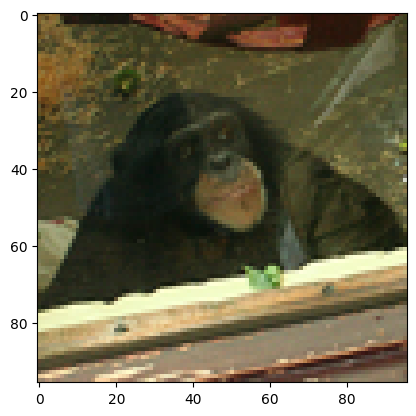

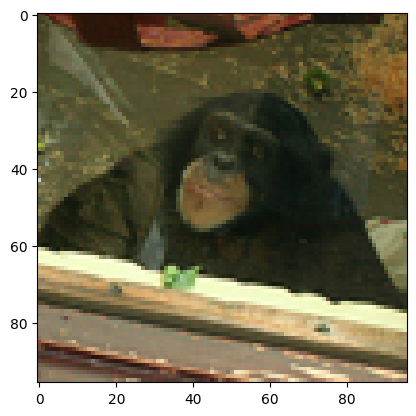

In [8]:
i = random.randint(0,5400)
# i = 0
plot_image(train_images[i])
if i - 3200 >= 0:
    plot_image(train_images[i-3200])
else :
    plot_image(train_images[i+3200])

In [33]:
print(train_images.shape)
print(train_labels.shape)

(6400, 96, 96, 3)
(6400, 10)


### Translation, Shearing, Zooming: Zoom in or out on the image.

In [34]:
# Preprocessing function to add random noise
def add_random_noise(x):
    noise = np.random.normal(0, 0.1, x.shape)  # Generate random noise
    noisy_image = x + noise  # Add noise to the image
    return noisy_image

# Preprocessing function to adjust contrast
def adjust_contrast(x):
    return x
    # contrast_factor = np.random.uniform(0.8, 1.2)  # Adjust contrast by random factor
    # adjusted_image = (x - np.mean(x)) * contrast_factor + np.mean(x)
    # return adjusted_image

def gaussian_blur(x):
    if random.random() <= 0.5 :
        return cv2.GaussianBlur(x, (5, 5), 0)
    else :
        return x

In [35]:
step2 = ImageDataGenerator(
    width_shift_range=0.15,  # Random horizontal shift by 20% of image width
    height_shift_range=0.15,  # Random vertical shift by 20% of image height
    zoom_range=0.2,  # Random zoom in/out by 20%
    shear_range=0.2,
    brightness_range=[0.9, 1.1],  # Random brightness adjustment between 0.5 and 1.5
    preprocessing_function=lambda x: gaussian_blur(adjust_contrast(add_random_noise(x))),  # Gaussian blur with kernel size of (5, 5)
    fill_mode= 'reflect'
)

In [36]:
augmented_generator = step2.flow(train_images.reshape((-1, 96, 96, 3)), train_labels, batch_size=1)

# Generate augmented images and corresponding labels
augmented_images = []
augmented_labels = []
num_augmented_images = 0

for _ in range(6400):
    batch = augmented_generator.next()
    augmented_images.append(batch[0][0].astype(np.uint8))
    augmented_labels.append(batch[1])
    num_augmented_images += 1

# Convert the augmented images and labels back to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# # Reshape the augmented images back to the original shape
# augmented_images = augmented_images.reshape((-1, 96, 96, 3))

# Verify the shape of the augmented images and labels
print(augmented_images.shape)  # (6400, 96, 96, 3)
print(augmented_labels.shape)  # (6400, num_classes)

    

(6400, 96, 96, 3)
(6400, 1, 10)


In [37]:
augmented_labels = augmented_labels.reshape(6400,10)

In [38]:
augmented_labels[4]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

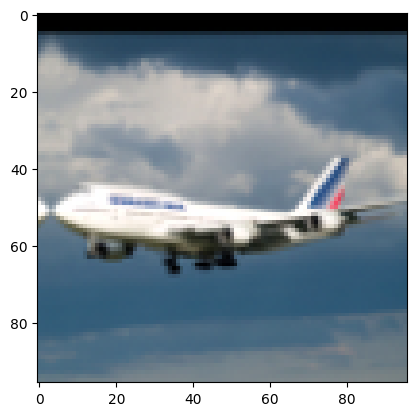

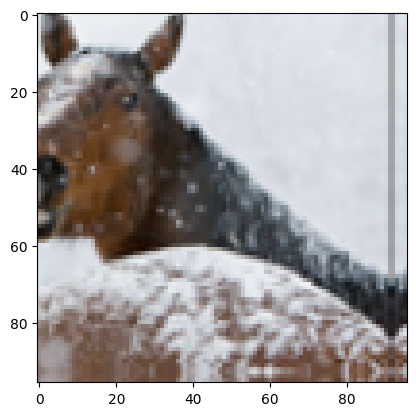

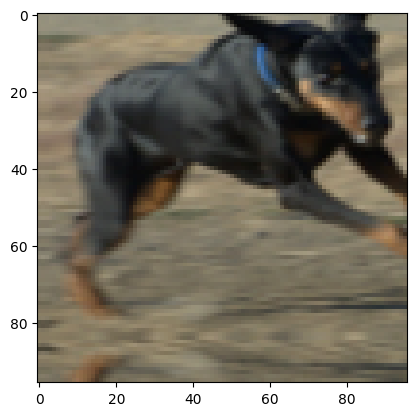

In [39]:
count = 0
for image in augmented_images :
    if count > 2:
        break
    plot_image(image)
    count+=1

In [40]:
# Charger une nouvelle image à prédire
image_path = 'chemin/vers/la/nouvelle/image.jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(96, 96))
image = tf.keras.preprocessing.image.img_to_array(image)
image = image / 255.0  # Normalisation

# Prédiction de l'image
prediction = model.predict(tf.expand_dims(image, axis=0))
predicted_class = tf.argmax(prediction, axis=1)


FileNotFoundError: [Errno 2] No such file or directory: 'chemin/vers/la/nouvelle/image.jpg'

## Pre trained model

## Semi-supervised Learning
### Idée
Dans le cas d'un jeu de données avec des données labellisées et des donnnées non labellisées, l'apprentissage semi supervisé permet d'exploiter l'ensemble du jeu de données. Dans notre cas nous allons utiliser un autoencodeur. 
### Auto Encodeur
Un autoencodeur est un réseau de neurone qu'on décompose en 3 éléments. La phase d'encodage, l'espace latent et la phase de décodage.
- L'encodage : C'est un phase qui va être entrainée à résumer nos données d'entrée dans un espace de plus petite dimension. De cette façon, seules les informations les plus imporantes de chaques données sont retenues.
- L'espace latent : C'est l'espace dans lequel nos données sont représentées après la phase d'encodage. Sa dimension sera inférieure à celle de l'espace de départ. Cette plus faible dimension va contraindre notre réseau de neurone à ne conserverver que les éléments les plus importants des données. 
- Le décodage : Cette phase fait le chemin inverse de l'encodage. Elle prend les données dans l'espace latent et va les emmener dans l'espace de départ. Dans notre cas, cette phase nous servira pour entrainer l'encodeur. 

### Un Auto Encodeur pour les classer tous

Dans notre cas nous voullons construire un classifier. Un réseau de neurones qui va de l'espace de départ vers l'espace de départ ne nous convient pas.
Cependant, l'espace latent est exploitable. En effet, celui-ci regorge d'informations importantes sur nos données. Il a été construit avec une grande quantité de données non labellisées. Nous allons donc remplacer le décodeur par un classifier et garder l'encoceur et l'espace latent.



![image](https://blog.paperspace.com/content/images/2021/12/image-12.png)

### Charger les images non labellisées 

In [46]:
UNLABELED_DATA_PATH = './data/stl10_binary/unlabeled_X.bin'
unlabeled_images = read_all_images(UNLABELED_DATA_PATH)

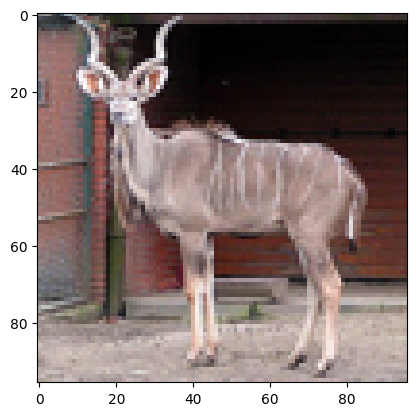

(100000, 96, 96, 3)

In [48]:
plot_image(unlabeled_images[0])
unlabeled_images.shape

In [69]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense
from sklearn.model_selection import train_test_split

# Prétraitement des données
input_shape = (96, 96, 3)
latent_dim = 32
nb_of_unlabeled_images = 10000

# Division des données non labellisées en ensembles d'entraînement et de validation
train_images_unlabeled, val_images_unlabeled = train_test_split(unlabeled_images[:nb_of_unlabeled_images], test_size=0.2, random_state=42)

# Normalisation des images
train_images_unlabeled = train_images_unlabeled / 255.0
val_images_unlabeled = val_images_unlabeled / 255.0

# Construction de l'autoencodeur
input_img = Input(shape=input_shape)

# Encodeur
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
encoded = Dense(latent_dim, activation='relu', name='encoded')(x)

# Décodeur
x = Dense(12*12*128, activation='relu')(encoded)
x = tf.reshape(x, shape=(-1, 12, 12, 128))
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Modèle de l'autoencodeur
autoencoder = Model(input_img, decoded)

autoencoder.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 48, 48, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 24, 24, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_50 (Conv2D)          (None, 24, 24, 128)       738

In [70]:
# Compilation et entraînement de l'autoencodeur
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(train_images_unlabeled, train_images_unlabeled, epochs=5, batch_size=32, validation_data=(val_images_unlabeled, val_images_unlabeled))

Epoch 1/5
250/250 [==============================] - 235s 928ms/step - loss: 0.0425 - val_loss: 0.0303
Epoch 2/5
250/250 [==============================] - 214s 856ms/step - loss: 0.0289 - val_loss: 0.0265
Epoch 3/5
250/250 [==============================] - 208s 831ms/step - loss: 0.0262 - val_loss: 0.0251
Epoch 4/5
250/250 [==============================] - 208s 831ms/step - loss: 0.0253 - val_loss: 0.0251
Epoch 5/5
250/250 [==============================] - 207s 827ms/step - loss: 0.0249 - val_loss: 0.0244


In [60]:

# Extraction des caractéristiques avec l'encodeur
encoder = Model(input_img, encoded)
features = encoder.predict(unlabeled_images[:nb_of_unlabeled_images])
print(features.shape)

94/94 [==============================] - 6s 60ms/step
(3000, 32)


In [71]:
encoder_input = autoencoder.input
encoder_output = autoencoder.get_layer('encoded').output

# Ajout de la couche Dense de dimension 10 pour la classification
x = Dense(32, activation='linear', name='last_dense')(encoder_output)
classification_layer = Dense(10, activation='softmax', name='classification')(x)

# Création du modèle complet avec l'encoder et la nouvelle couche de classification
classification_model = Model(inputs=encoder_input, outputs=classification_layer)

# Compilation du modèle
classification_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


history_classification_model = classification_model.fit(train_images, 
                                                        train_labels, 
                                                        epochs=3,
                                                        validation_data=(valid_images, valid_labels),
                                                        batch_size = 32,)

Epoch 1/10
25/25 [==============================] - 33s 1s/step - loss: 35.9046 - accuracy: 0.0991 - val_loss: 2.3021 - val_accuracy: 0.1025
Epoch 2/10
25/25 [==============================] - 34s 1s/step - loss: 2.3027 - accuracy: 0.1016 - val_loss: 2.3024 - val_accuracy: 0.1025
Epoch 3/10
25/25 [==============================] - 34s 1s/step - loss: 2.3026 - accuracy: 0.1016 - val_loss: 2.3028 - val_accuracy: 0.1025
Epoch 4/10
25/25 [==============================] - 33s 1s/step - loss: 2.3025 - accuracy: 0.1022 - val_loss: 2.3031 - val_accuracy: 0.0862
Epoch 5/10
25/25 [==============================] - 32s 1s/step - loss: 2.3023 - accuracy: 0.1050 - val_loss: 2.3036 - val_accuracy: 0.0862
Epoch 6/10
25/25 [==============================] - 34s 1s/step - loss: 2.3022 - accuracy: 0.1050 - val_loss: 2.3039 - val_accuracy: 0.0862
Epoch 7/10
25/25 [==============================] - 36s 1s/step - loss: 2.3021 - accuracy: 0.1050 - val_loss: 2.3042 - val_accuracy: 0.0862
Epoch 8/10
25/25 [=

In [73]:
# Évaluation des performances sur l'ensemble de test
test_loss_classification_model, test_accuracy_classification_model = classification_model.evaluate(test_images, test_labels)
print('Test Loss:', test_loss_classification_model)
print('Test Accuracy:', test_accuracy_classification_model)


32/32 [==============================] - 2s 67ms/step - loss: 2.3044 - accuracy: 0.0950
Test Loss: 2.304436683654785
Test Accuracy: 0.0949999988079071


In [61]:

# Ajout des caractéristiques aux données étiquetées
# extended_data = np.concatenate([labeled_data, features])

# Entraînement du modèle de classification sur les données labellisées
model_ae_class = tf.keras.Sequential([
    Dense(128, activation='linear'),
    Dense(num_classes, activation='softmax')
])


model_ae_class.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit(extended_data, extended_labels, epochs=10, validation_data=(validation_data, validation_labels))
history_ae_class = model_ae_class.fit(features,
                                      labels, 
                                      epochs=2, 
                                      validation_data=(valid_images, valid_labels),
                                      batch_size = 32)


# Évaluation des performances sur l'ensemble de test
test_loss_ae_class, test_accuracy_ae_class = model.evaluate(test_images, test_labels)
print('Test Loss:', test_loss_ae_class)
print('Test Accuracy:', test_accuracy_ae_class)



ValueError: Data cardinality is ambiguous:
  x sizes: 3000
  y sizes: 5000
Make sure all arrays contain the same number of samples.